<a href="https://colab.research.google.com/github/akulkarni14/SDL-Practicals/blob/main/S%26DL_PR5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shapes: (54000, 784) (54000, 10) (6000, 784) (6000, 10) (10000, 784)
Epoch 1/10 - 3.17s | Train loss: 0.4179, acc: 88.08% | Val loss: 0.2225, acc: 93.68%
Epoch 2/10 - 5.53s | Train loss: 0.2032, acc: 94.06% | Val loss: 0.1631, acc: 95.35%
Epoch 3/10 - 3.62s | Train loss: 0.1522, acc: 95.52% | Val loss: 0.1345, acc: 96.23%
Epoch 4/10 - 3.14s | Train loss: 0.1228, acc: 96.41% | Val loss: 0.1148, acc: 96.75%
Epoch 5/10 - 3.21s | Train loss: 0.1023, acc: 97.05% | Val loss: 0.1042, acc: 96.95%
Epoch 6/10 - 6.00s | Train loss: 0.0871, acc: 97.51% | Val loss: 0.0931, acc: 97.33%
Epoch 7/10 - 3.23s | Train loss: 0.0747, acc: 97.87% | Val loss: 0.0890, acc: 97.38%
Epoch 8/10 - 3.19s | Train loss: 0.0658, acc: 98.11% | Val loss: 0.0866, acc: 97.43%
Epoch 9/10 - 5.27s | Train loss: 0.0577, acc: 98.39% | Val loss: 0.0793, acc: 97.75%
Epoch 10/10 - 4.07s | Train loss: 0.0514, acc: 98.57% | Val loss: 0.0783, acc: 97.85%

Test loss: 0.0779, Test

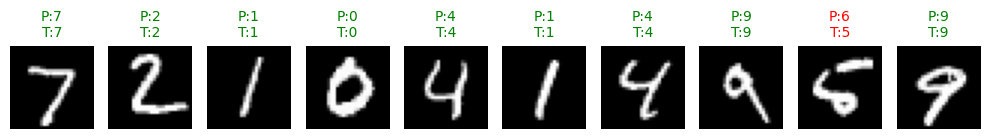

In [3]:
# corrected_mlp_mnist.py
import numpy as np
import time
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


def relu(x):
    return np.maximum(0, x)


def relu_deriv(x):
    # x is pre-activation z; derivative is 1 for z>0
    return (x > 0).astype(float)


def cross_entropy_loss(pred_probs, true_onehot):
    eps = 1e-12
    clipped = np.clip(pred_probs, eps, 1 - eps)
    return -np.mean(np.sum(true_onehot * np.log(clipped), axis=1))


def accuracy(pred_probs, labels):
    preds = np.argmax(pred_probs, axis=1)
    return np.mean(preds == labels)


class MLP:
    def __init__(self, layer_sizes, seed=42):
        np.random.seed(seed)
        self.L = len(layer_sizes) - 1
        self.sizes = layer_sizes
        self.W = []
        self.b = []
        for i in range(self.L):
            fan_in = layer_sizes[i]
            fan_out = layer_sizes[i + 1]
            # He initialization for ReLU hidden layers
            W = np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / fan_in)
            b = np.zeros((1, fan_out))
            self.W.append(W.astype(np.float32))
            self.b.append(b.astype(np.float32))

    def forward(self, X):
        a = X
        activations = [a]
        zs = []
        # hidden layers (ReLU)
        for i in range(self.L - 1):
            z = a.dot(self.W[i]) + self.b[i]
            zs.append(z)
            a = relu(z)
            activations.append(a)
        # output layer (softmax)
        z = a.dot(self.W[-1]) + self.b[-1]
        zs.append(z)
        probs = softmax(z)
        activations.append(probs)
        return zs, activations

    def backward(self, X, y_onehot, zs, activations):
        N = X.shape[0]
        dW = [None] * self.L
        db = [None] * self.L

        probs = activations[-1]
        # gradient of loss w.r.t logits -> (probs - y) / N
        delta = (probs - y_onehot) / N

        # last layer grads
        a_prev = activations[-2]
        dW[-1] = a_prev.T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)

        # backprop through hidden layers
        for l in range(self.L - 2, -1, -1):
            z = zs[l]
            da = delta.dot(self.W[l + 1].T)
            delta = da * relu_deriv(z)
            a_prev = activations[l]
            dW[l] = a_prev.T.dot(delta)
            db[l] = np.sum(delta, axis=0, keepdims=True)

        return dW, db

    def update_params(self, dW, db, lr, weight_decay=0.0):
        for i in range(self.L):
            self.W[i] -= lr * (dW[i] + weight_decay * self.W[i])
            self.b[i] -= lr * db[i]

    def predict_proba(self, X):
        _, activations = self.forward(X)
        return activations[-1]

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


def train(model, X_train, y_train_onehot, X_val, y_val_onehot,
          epochs=10, batch_size=128, lr=0.1, weight_decay=0.0):
    n = X_train.shape[0]
    num_batches = int(np.ceil(n / batch_size))

    for epoch in range(1, epochs + 1):
        perm = np.random.permutation(n)
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train_onehot[perm]

        epoch_loss = 0.0
        epoch_acc = 0.0
        start = time.time()

        for b in range(num_batches):
            i0 = b * batch_size
            i1 = min((b + 1) * batch_size, n)
            Xb = X_train_shuffled[i0:i1]
            yb = y_train_shuffled[i0:i1]

            zs, acts = model.forward(Xb)
            loss = cross_entropy_loss(acts[-1], yb)

            dW, db = model.backward(Xb, yb, zs, acts)
            model.update_params(dW, db, lr, weight_decay)

            epoch_loss += loss * (i1 - i0)
            epoch_acc += accuracy(acts[-1], np.argmax(yb, axis=1)) * (i1 - i0)

        epoch_loss /= n
        epoch_acc /= n

        val_probs = model.predict_proba(X_val)
        val_loss = cross_entropy_loss(val_probs, y_val_onehot)
        val_acc = accuracy(val_probs, np.argmax(y_val_onehot, axis=1))

        print(
            f"Epoch {epoch}/{epochs} - {time.time()-start:.2f}s | "
            f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc*100:.2f}% | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%"
        )


def load_mnist_flatten(normalize=True, validation_split=0.1):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape((-1, 28 * 28)).astype(np.float32)
    x_test = x_test.reshape((-1, 28 * 28)).astype(np.float32)
    if normalize:
        x_train /= 255.0
        x_test /= 255.0

    n_val = int(len(x_train) * validation_split)
    X_val, y_val = x_train[:n_val], y_train[:n_val]
    X_train, y_train = x_train[n_val:], y_train[n_val:]

    y_train_oh = to_categorical(y_train, num_classes=10).astype(np.float32)
    y_val_oh = to_categorical(y_val, num_classes=10).astype(np.float32)
    y_test_oh = to_categorical(y_test, num_classes=10).astype(np.float32)

    return X_train, y_train_oh, X_val, y_val_oh, x_test, y_test_oh, y_test


def main():
    hidden_sizes = [256, 128]
    layer_sizes = [28 * 28] + hidden_sizes + [10]
    epochs = 10
    batch_size = 128
    lr = 0.1
    weight_decay = 1e-4

    X_train, y_train_oh, X_val, y_val_oh, X_test, y_test_oh, y_test_labels = load_mnist_flatten()
    print("Data shapes:", X_train.shape, y_train_oh.shape, X_val.shape, y_val_oh.shape, X_test.shape)

    model = MLP(layer_sizes)
    train(model, X_train, y_train_oh, X_val, y_val_oh,
          epochs=epochs, batch_size=batch_size, lr=lr, weight_decay=weight_decay)

    test_probs = model.predict_proba(X_test)
    test_loss = cross_entropy_loss(test_probs, y_test_oh)
    test_acc = accuracy(test_probs, y_test_labels)
    print(f"\nTest loss: {test_loss:.4f}, Test accuracy: {test_acc*100:.2f}%")

    # show some predictions
    num_samples = 10
    preds = np.argmax(test_probs[:num_samples], axis=1)
    true_labels = y_test_labels[:num_samples]
    images = X_test[:num_samples].reshape(-1, 28, 28)

    print("Predicted:", preds)
    print("Ground truth:", true_labels)

    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap="gray")
        color = "green" if preds[i] == true_labels[i] else "red"
        plt.title(f"P:{preds[i]}\nT:{true_labels[i]}", fontsize=10, color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
